# 1. Combinatorial Regulation

a. In order to model combinatorial regulation by 2 or 3 TFs, write a separate response function for each of the following logic gates:

  -- **A** AND **B** where **B** binds cooperatively such that *n* B molecules are required for its TF activity
  
  -- **A** OR **B** where **B** binds cooperatively such that *n* B molecules are required for its TF activity
  
  -- **A** AND (NOT **B**) where **B** binds cooperatively such that *n* B molecules are required for its TF activity
  
  -- **A** OR (NOT **B**) where **B** binds cooperatively such that *n* B molecules are required for its TF activity
  
  -- [**A** AND (NOT **B**)] OR **C** where **C** binds cooperatively such that *n* B molecules are required for its TF activity
  

  

In [4]:
# code goes here

#demo funciton (you will call your own)
def demo_response(A, B):
    return(A+B)

# AND gate where A binds alone and B binds cooperatively, 
# so that h molecules of B are required as a complex it can do its job
def AND_gate(A,B,h):
    A_bound = A /(A+Ka)
    B_bound = (B**h) /(B**h + Kb**h)
    return (A_bound * B_bound)

def OR_gate(A,B,h):
    A_bound = A /(A+Ka)
    B_bound = (B**h) /(B**h + Kb**h)
    return (A_bound + B_bound)

def AND_NOT_gate(A,B,h):
    A_bound = A /(A+Ka)
    B_bound = (Kb**h) /(B**h + Kb**h) # inhibitor!
    return (A_bound * B_bound)

def OR_NOT_gate(A,B,h):
    A_bound = A /(A+Ka)
    B_bound = (Kb**h) /(B**h + Kb**h) # inhibitor!
    return (A_bound + B_bound)

# [A AND (NOT B)] OR C

def A_AND_NOT_B__OR_C_gate(A,B,C,h):
    A_bound = A /(A+Ka)
    B_bound = (Kb**h) /(B**h + Kb**h) # inhibitor!
    C_bound = C /(C+Kc)
    return (A_bound * B_bound + C_bound)

Ka = 1
Kb = 1
Kc = 1


In order to test if these funcitons work correctly, you can use the following 3D plots to visualize the response of the gene regualted by each gate:

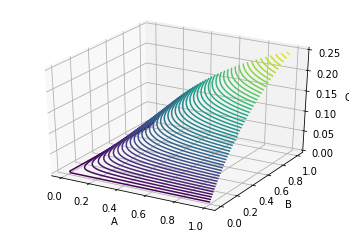

In [5]:
#demo code: 3D surface plots

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# this sets the range of A and  values you want to plot over, and the density of your points along A

a = np.linspace(0, 1, 50) 
b = np.linspace(0, 1, 50) 

A, B = np.meshgrid(a, b) # thid creates a 2D grid you want to plot the results for
G = AND_gate(A, B,1)

# this gives you a contourplot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(A, B, G, 50, cmap='viridis')
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_zlabel('G')
#ax.view_init(60, 35)
   # this allows you to change the angle; comment it out and compare
plt.show()

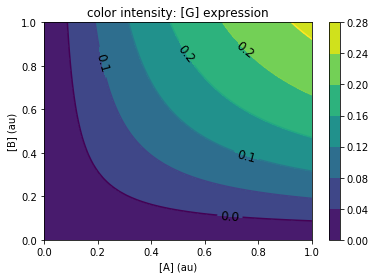

In [4]:
# demo code: 2D contour plot -- sometimes a 2D projection is more useful!

# plotting the error for the QSS approximation
plt.figure()
contour = plt.contour(A, B, G)
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour_filled = plt.contourf(A, B, G)
plt.colorbar(contour_filled)
plt.title('color intensity: [G] expression')
plt.xlabel('[A] (au)')
plt.ylabel('[B] (au)')
plt.show()

Now, use the examples above to plot a 3D plot and then a contour plot for each response function your defined 

In [5]:
#your code goes here!

# Coherent Feed-forward loops

Now that you have funcitons for combinatorial regulation, it's time to test the behavior of FFLs. To this end, write a **differential equation function** that can run the dynamkics of a type-1 coherent FFL with the AND funciton you wrote above (cooperative for the intermediate TF), then use code from last week to run this for the following time-dependent X signal:

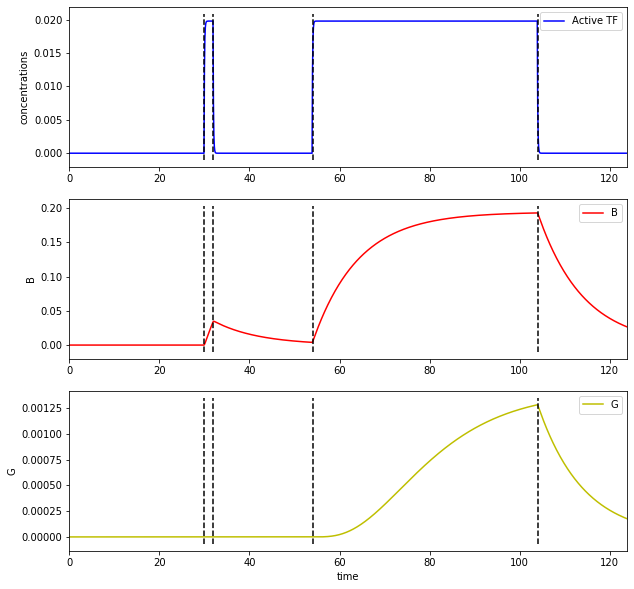

In [7]:
from scipy.integrate import odeint

# Af is free A TF, not active
# Aa is inducer-bound TF, active
# x is the inducer of A

# parameter set we left with in class:
k_on = 0.1 #inducer binding rate to A 
k_off = 0.1 #inducer dissociation rate to A 
Ka = 1
Kb = 1
kB_deg = 0.1
kG_deg = 0.1
n = 1

# problems reproducing expected AND-gate C-FFL behavior: 
    #once the inducer bound A, it let go very slowly. 
    # We need A to respond nearly immediately to loss of X by crasing! 
    # to alleviate this, let's set the dissociation constant k_off to be much higher    

k_off = 10 #inducer dissociation rate to A; 
           # comment this out if you want to run original param. form lab

# this fixes the behaviuor of A, and B looks good too.
   # Gene does blip a bit at the short pulse, hangs around long, and the delay is not that impressive.
   # both of these indicate that B is too potent even at low levels 
   # as a result, there is not much lag between B and G
   # one potentially easy fix is to render B cooperative (note that we had n = 1 above) 

n = 3  # now, a trimer B is required to make a repressor 
       # comment this out if you want to run original param. form lab

def Coherent_Type1_FFL_system(state,t):
    [Af,Aa,B,G] = state
    d_Af = -k_on*Af*x + k_off*Aa
    d_Aa =  k_on*Af*x - k_off*Aa
    d_B = Aa / (Aa + Ka) - kB_deg * B
    d_G = AND_gate(Aa,B,n) - kG_deg*G
    return [d_Af,d_Aa,d_B,d_G]

Sx_signal = [(0,30),(1,32),(0,54),(1,104),(0,124)]

# this sets the initial state; we use these to add each interval's results to it
Af0 = 2
state = [[Af0,0,0,0]] 
# I start the system with no enzyme and S0 amount of free substrate

process = state
# process will accumulate the results from chunks of run

time = [0]

# this for loop runs each unique interval separately, and accumulates the results

for (inducer,time_int) in Sx_signal:
    t = np.arange(0, time_int-time[-1], 0.1) 
    # this sets the next time-interval from the end of the previous one to the next end-point
    init_state = state[-1]
    # this sets the initial state for this interval to the last state of the previous one
    # that said, we are changing the level of inducer for each interval, so we will override its value. 
    # since the code above works with the MM equation, here I will modulate the enzyme level as if it were equal to the inducer value we are changing in each steps
    x = inducer
    state = odeint(Coherent_Type1_FFL_system, init_state, t)
    process = np.concatenate((process,state),axis=0)
    time = np.concatenate((time,time[-1]+t),axis=0)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(311)
plt.xlim(0,time[-1])
plt.plot(time,process[:, 1],'b-',label = 'Active TF')
(ymin, ymax) = ax.get_ylim()

for (inducer,time_int) in Sx_signal:
    plt.plot([time_int,time_int],[ymin,ymax],'k--')

plt.ylabel('concentrations')
plt.legend()

ax = fig.add_subplot(312)
plt.xlim(0,time[-1])
plt.plot(time,process[:, 2],'r-',label = 'B')
(ymin, ymax) = ax.get_ylim()
for (inducer,time_int) in Sx_signal:
    plt.plot([time_int,time_int],[ymin,ymax],'k--')
#plt.plot([time[0],time[-1]],[Tr_Y,Tr_Y],'k--',label = 'threshold')
  # this can add a threshold
plt.ylabel('B')
plt.legend()

ax = fig.add_subplot(313)
plt.xlim(0,time[-1])
plt.plot(time,process[:, 3],'y-',label = 'G')
(ymin, ymax) = ax.get_ylim()

for (inducer,time_int) in Sx_signal:
    plt.plot([time_int,time_int],[ymin,ymax],'k--')
plt.ylabel('G')
plt.legend()
plt.xlabel('time')
plt.show()


Do you see the correct delays at the arrival, but not the dissapearance of the singal? Are your rates at fault? 

-- Given that we did not introduce a B threshold into the equations, can cooperativity of this transcription factor serve a similar purpose?

Next, write a **differential equation function** for the type-1 coherent FFL with the OR function and examine it's behavior. 

   -- Do you see the expected delays? How do they depend on cooperativity?

In [10]:
# your code goes here
# use the logic above to tweak your parameters until the circuit is working as expected.


# Incoherent Feed-forward loops

Write a **differential equation function** for the type-1 incoherent FFL with the AND function, and examine it's behavior. 

   -- Instead of a series of pulses, create an input to X that takes it through a series of fold-change steps: 1 -> 2-> 20 -> 200
   
   -- Do you see pulses?
    
   -- Does your circuit do Fold Change Detection? If not, can you make a version of the AND NOT gate that uses exlcusive binding (like in the exam paper)? Does this help?

In [ ]:
#your code goes here
# match your parameters to those in the Midterm 1 paper to get your circuit to perform fold-change detection!
# try the following time course to see how it responds to repeated pulses

Sx_signal = [(0,30),(1,32),(0,54),(1,104),(2,124),(4,144)]


# Bistable Switch

Write a **differential equation function** for the bistable switch below, using the gate funtions you created for 3 TFs at the start of this worksheet (note that X and Y will be exteral signals, the ODEs do not need to track them):

<div>
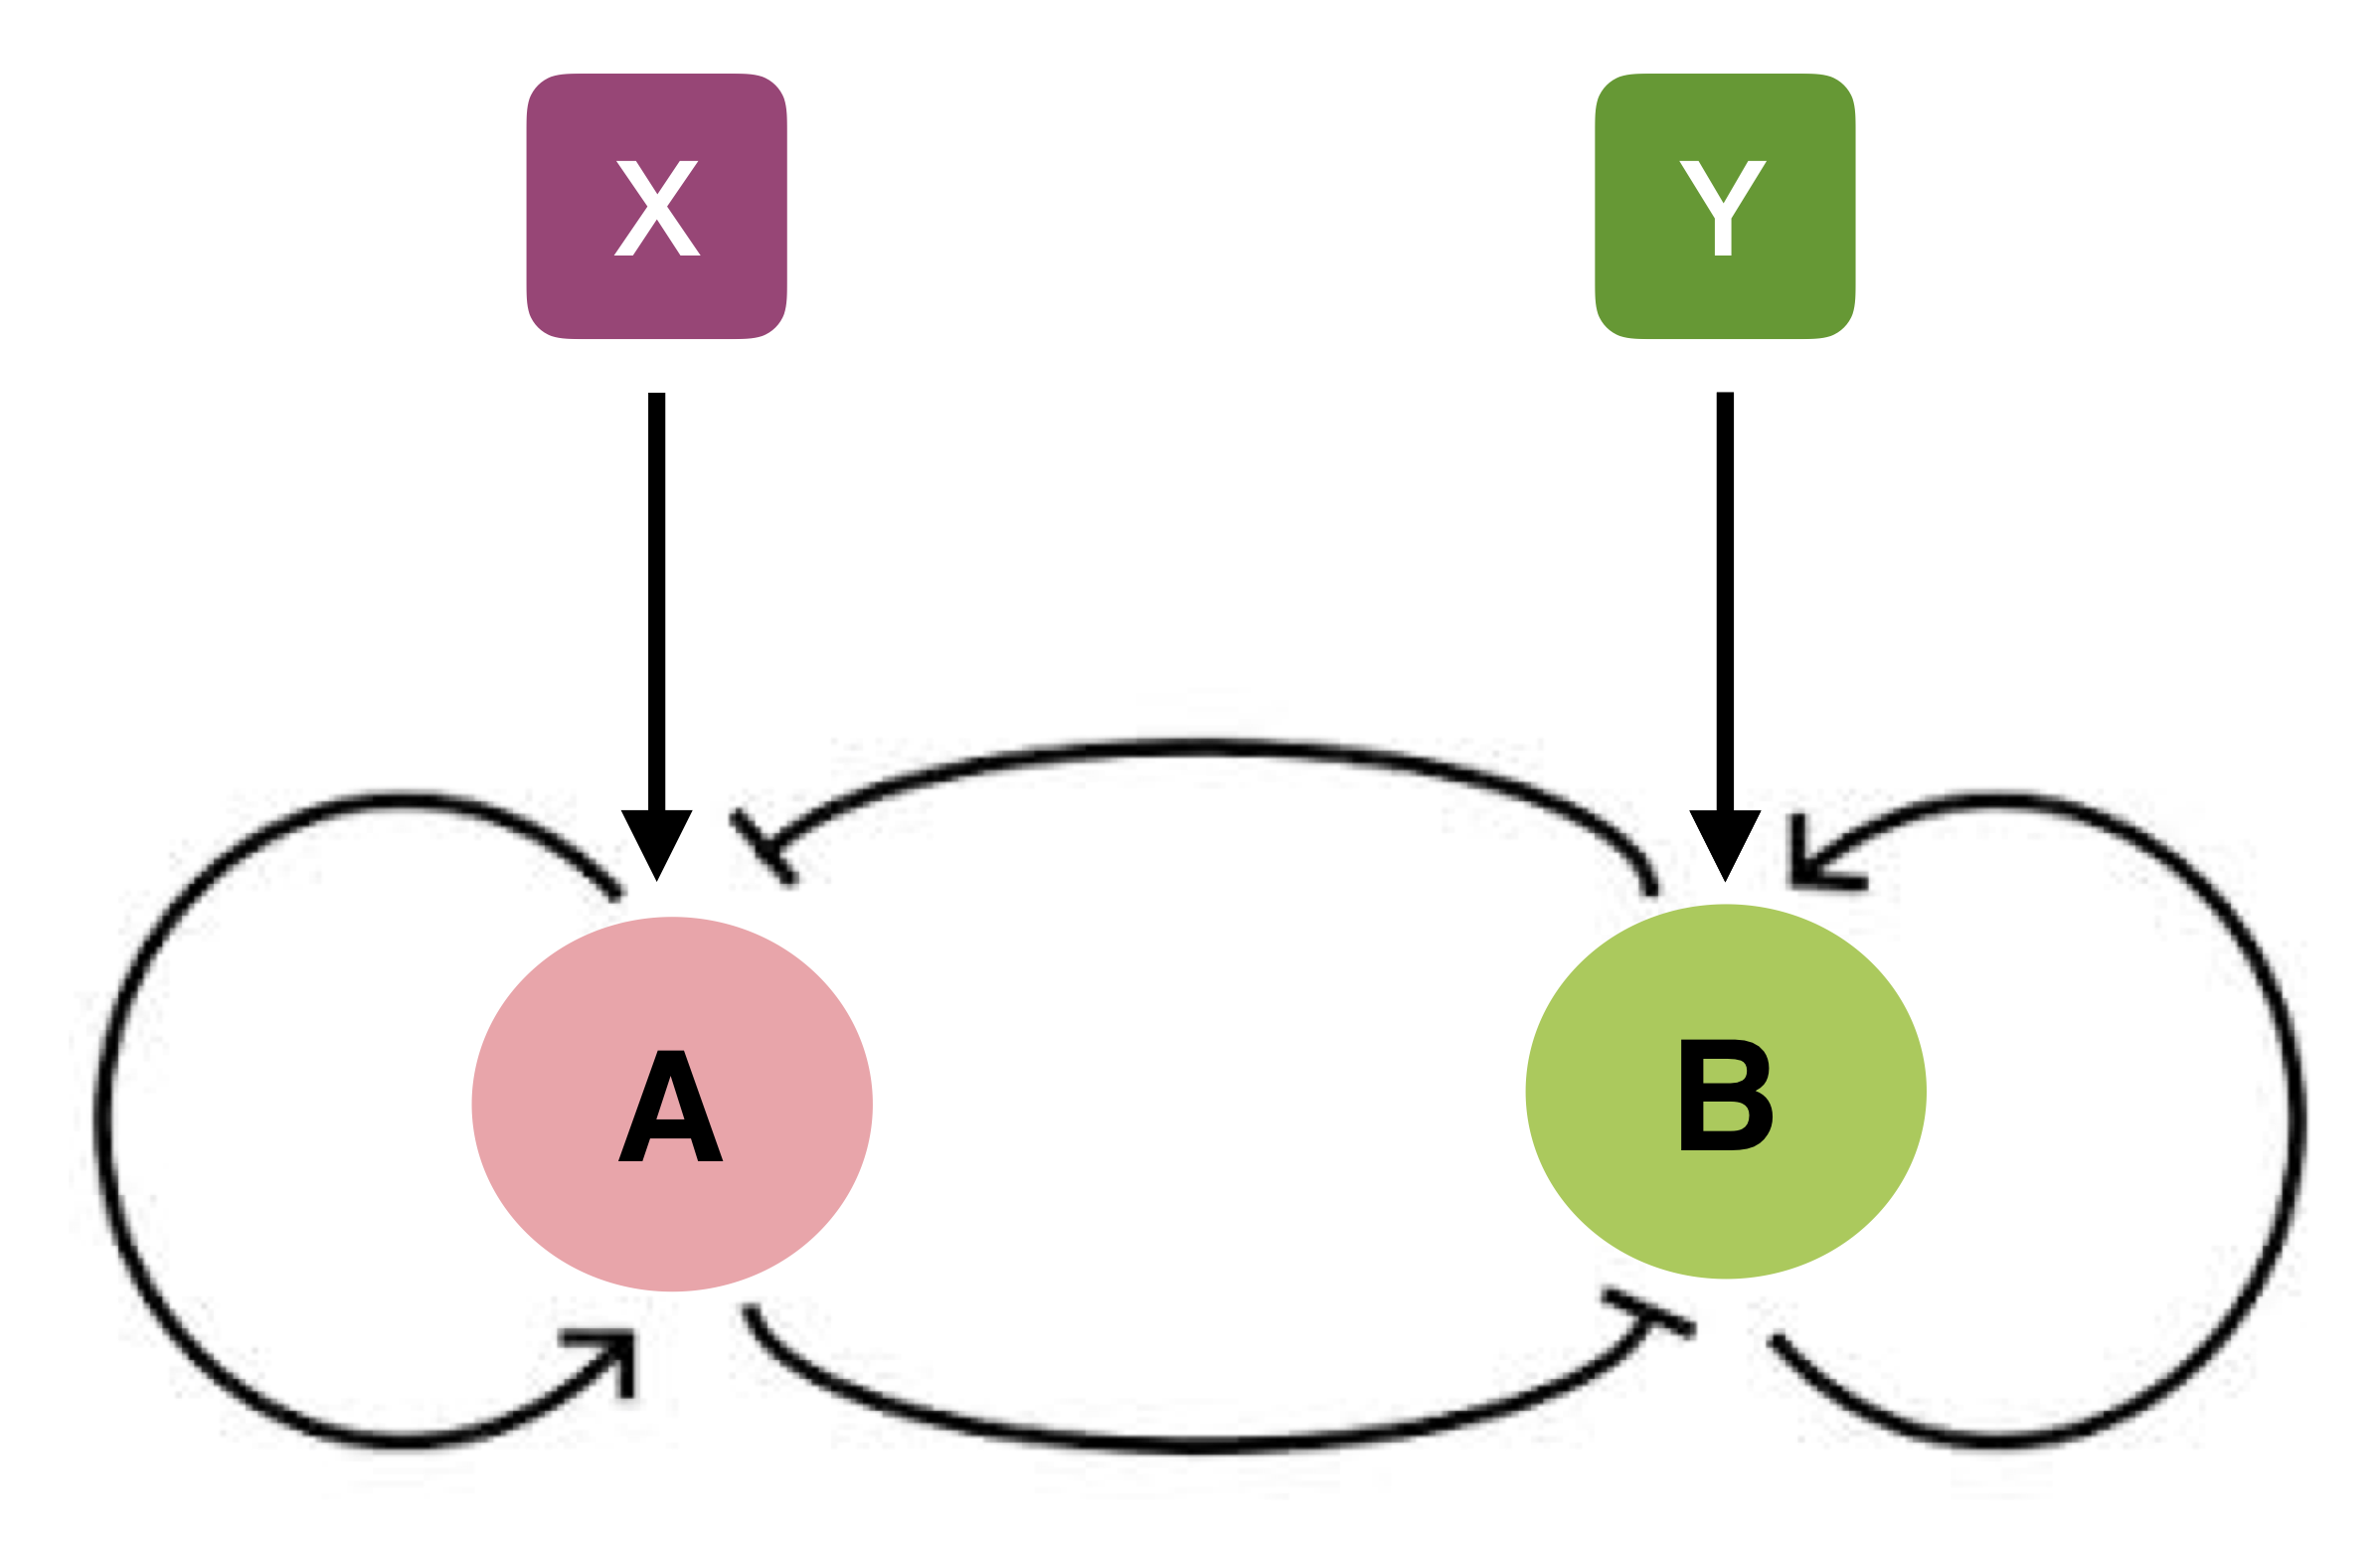 
</div>

-- Start this switch from an initial state with high *A* for a time, then expose it to a signal Y, which dissapears after a timeperiod. 

-- What happens? Change the level of Y from low to high and see if you can find the threshold that flips the switch. 

-- Does the switch flip back to a high-A state after the signal Y dissapears?

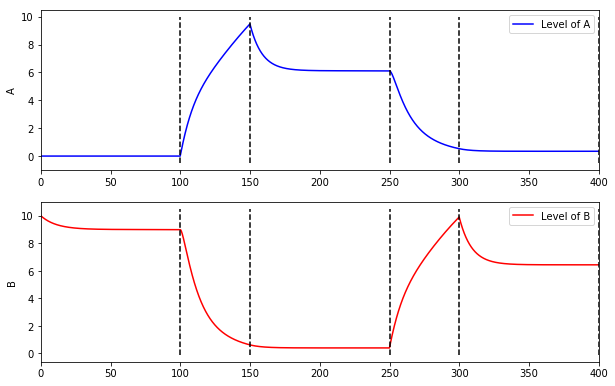

In [24]:
# let's treat X and Y as TFs that stay constant unless we manipulate them form the outside
# we no longer worry about an inducer, for either A or B!

# Here is a version of the gate we defined at the beginning where
# both A and B can act coopreatively

def A_AND_NOT_B__OR_C_gate(A,ha,B,hb,C):
    A_bound = (A**ha) /(A**ha + Ka**ha)
    B_bound = (Kb**hb) /(B**hb + Kb**hb) # inhibitor!
    C_bound = C /(C+Kc) # C has MM kinetics, no cooperativity
    return (A_bound * B_bound + C_bound)

def Bistable_Switch_system(state,t):
    [A,B] = state
    d_A = A_AND_NOT_B__OR_C_gate(A,h_AA,B,h_BA,X) - kA_deg * A 
      # logic for transcription of A is driven by [A AND NOT B] OR X
        # note that X is a constant in this funciton; need to define outside  
        # it takes h_AA molecules of A to induce its own expression
        # it takes h_BA molecules of B to block A
    d_B = A_AND_NOT_B__OR_C_gate(B,h_BB,A,h_AB,Y) - kB_deg * B 
        # it takes h_BB molecules of B to induce its own expression
        # it takes h_AB molecules of A to block N
    return [d_A,d_B]

#let's make the switch completely symmetric:
Ka = 1
Kb = 1
Kc = 1
kA_deg = 0.1
kB_deg = 0.1
h_AA = 1
h_BB = 1
h_AB = 1
h_BA = 1

# this will define our X-Y input pair, and the time each value lasts for
# we will turn the switch from B to A state, then back!
segment_1 = (0,0,100) # for the first 100 steps, we leave the SW alone
segment_2 = (1,0,150) # for the next 50 steps, we turn on X
segment_3 = (0,0,250) # for the next 100 steps, we leave the SW alone
segment_4 = (0,1,300) # for the next 50 steps, we turn on Y
segment_5 = (0,0,400) # for the last 100 steps, we leave the SW alone

XY_signal = [segment_1,segment_2,segment_3,segment_4,segment_5]

# this sets the initial state; we use these to add each interval's results to it
state = [[0,10]] # start with a LOT of B -> get to the B-high / A-low state
# process will accumulate the results from chunks of run
process = state

time = [0]
# this for loop runs each unique interval separately, and accumulates the results

for (X,Y,time_int) in XY_signal:
    t = np.arange(0, time_int-time[-1], 0.1) 
    # this sets the next time-interval from the end of the previous one to the next end-point
    init_state = state[-1]
    # this sets the initial state for this interval to the last state of the previous one
    # that said, we are changing the level of inducer for each interval, so we will override its value. 
    # since the code above works with the MM equation, here I will modulate the enzyme level as if it were equal to the inducer value we are changing in each steps
    # X = inducer 
       # we no longer need this; 
       # we took care of X and Y by assigning them at the start of the loop
    state = odeint(Bistable_Switch_system, init_state, t)
    process = np.concatenate((process,state),axis=0)
    time = np.concatenate((time,time[-1]+t),axis=0)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(311)
plt.xlim(0,time[-1])
plt.plot(time,process[:, 0],'b-',label = 'Level of A')
(ymin, ymax) = ax.get_ylim()

for (X,Y,time_int) in XY_signal:
    plt.plot([time_int,time_int],[ymin,ymax],'k--')

plt.ylabel('A')
plt.legend()

ax = fig.add_subplot(312)
plt.xlim(0,time[-1])
plt.plot(time,process[:, 1],'r-',label = 'Level of B')
(ymin, ymax) = ax.get_ylim()
for (X,Y,time_int) in XY_signal:
    plt.plot([time_int,time_int],[ymin,ymax],'k--')
#plt.plot([time[0],time[-1]],[Tr_Y,Tr_Y],'k--',label = 'threshold')
  # this can add a threshold
plt.ylabel('B')
plt.legend()

plt.show()

Now that you have a working symmetric bistable switch, examine how the parameters and assymetry might affect its behavior
  
  1. play with the signal strengts in the XY_signal segments, and see what it takes to actually flip the switch. What is the threshold of X? Does it depend on the time you leave it on for?
  
  2. What happens if A is much better at inhibiting B than vice versa?